# Lunar Lander

In questo notebook esploreremo il problema del **Lunar Lander**, un classico ambiente di controllo sviluppato all'interno della libreria Gymnasium ([documentazione ufficiale](https://gymnasium.farama.org/environments/box2d/lunar_lander/)). L'obiettivo è guidare un lander spaziale verso un atterraggio sicuro tra due bandierine, ottimizzando l'uso del carburante e minimizzando la velocità d'impatto.

Utilizzeremo tecniche di Reinforcement Learning (RL), come SARSA e Q-Learning, per addestrare un agente a risolvere il problema. Inoltre, analizzeremo diversi approcci alla discretizzazione dello spazio degli stati e strategie per migliorare la stabilità della convergenza.

Siete pronti a far atterrare il vostro lander? 🚀✨

Come primo passo, importiamo le librerie necessarie all'esecuzione di questo notebook.

In [8]:
import gymnasium as gym
import random
from collections import defaultdict
from functools import reduce
from learn_utils import *
import numpy as np
import matplotlib.pyplot as plt

Ora creiamo l'ambiente gymnasium per il lander.

In [9]:
env = gym.make("LunarLander-v3", continuous=False, gravity=-10.0, enable_wind=False,
               wind_power=0, turbulence_power=0)

### Fase 0: Definizione dei Parametri di Apprendimento

Ora definiamo i parametri fondamentali per l'algoritmo di Q-learning, un metodo di Reinforcement Learning basato su una Q-table. 

- `ALPHA` rappresenta il learning rate, ovvero la velocità con cui il modello aggiorna i valori della Q-table dopo ogni esperienza.
- `GAMMA` è il fattore di sconto, che determina quanto il modello considera le ricompense future rispetto a quelle immediate.
- `EPSILON` inizializza la probabilità di exploration, regolando il bilanciamento tra exploration ed exploitation;
- `EPSILON_DECAY` specifica la velocità con cui `EPSILON` diminuisce
- `EPSILON_MIN` valore minimo oltre il quale `EPSILON` non può essere diminuito
- `ALPHA_DECAY` specifica la velocità con cui `ALPHA` diminuisce
- `ALPHA_MIN` valore minimo oltre il quale `ALPHA` non può essere diminuito. Ciò aiuta la stabilità della convergenza.
- `EPISODES` specifica il numero totale di episodi di addestramento, ovvero il numero di tentativi in cui l'agente interagirà con l'ambiente per apprendere una policy ottimale.

In [10]:
# Q-learning parameters. Values have been chose after some testing
ALPHA = 0.4
GAMMA = 1
EPSILON = 1
EPSILON_DECAY = 0.999 # 0.9977 #7 # 0.997
ALPHA_DECAY = 0.999
ALPHA_MIN = 0.01 # 0.01 # 0.01
EPSILON_MIN = 0.02 # 0.02 # 0.02
EPISODES = 9000

### Fase 1: Rappresentazione degli Stati

L'ambiente **Lunar Lander** è un ambiente di **controllo continuo** sviluppato all'interno della libreria **Gymnasium**, in cui un agente deve far atterrare in sicurezza un lander spaziale tra due bandierine, bilanciando l'uso del carburante e minimizzando la velocità d'impatto. Lo [stato](https://gymnasium.farama.org/environments/box2d/lunar_lander/) dell'ambiente è rappresentato da variabili continue, come la posizione, la velocità, l'angolo di inclinazione e la velocità angolare del lander, oltre a indicatori binari che segnalano il contatto con il suolo. Tuttavia, gli algoritmi di Reinforcement Learning (RL) basati su **Q-table** sono progettati per ambienti con **spazi di stato discreti**, in cui è possibile memorizzare e aggiornare valori di azione-stato in una tabella. Per applicare il **Q-learning** o **SARSA** in Lunar Lander, è quindi necessario **discretizzare** lo spazio degli stati, suddividendo le variabili continue in intervalli finiti. Questo permette di ridurre la complessità del problema, rendendo possibile l'apprendimento tabulare, sebbene a costo di una perdita di precisione rispetto a metodi più avanzati come le reti neurali.

Come effettuare questa discretizzazione? Un primo approccio, che funziona in ambienti di controllo continuo più semplici, è quello di dividere l'intervallo continuo in un numero finito di sotto-intervalli di lunghezza uniforme. Ad esempio, considerando esclusivamente la coordinata X dello stato del lander:

![title](img/lander-02.jpg)

Il numero di intervalli determina la precisione dell'approssimazione. Tuttavia, nel caso del Lander, affrontiamo una sfida: lo stato è rappresentato da una tupla di [8 elementi](https://gymnasium.farama.org/environments/box2d/lunar_lander/#observation-space), e aumentare la precisione comporta un'esplosione combinatoria del numero di stati, rendendo l'approccio impraticabile.

Un compromesso ragionevole è limitare il numero di partizioni a 6 (come mostrato in figura). Tuttavia, con una discretizzazione così grossolana, si introduce un nuovo problema: la scarsa risoluzione rischia di compromettere la precisione del controllo del lander, penalizzandone le prestazioni!

Quindi, come possiamo affrontare il problema? Abbandoniamo tutto o esploriamo un'altra strategia? Osserviamo più da vicino la dinamica del Lander. Se si trova a sinistra della prima bandierina, dovrà accendere il motore sinistro per dirigersi verso la zona di atterraggio; analogamente, se si trova oltre la seconda bandierina, sarà necessario attivare il motore destro. Tuttavia, all'interno dell'area del **Landing Pad**, il controllo deve essere molto più preciso: il lander deve stabilizzarsi accuratamente per garantire un atterraggio sicuro e in posizione orizzontale.

Seguendo questa logica, possiamo adottare una strategia più efficiente: mantenere una **maggiore risoluzione** nell'area di atterraggio, dove la precisione è cruciale, e **ridurre la granularità** nelle zone periferiche, dove le azioni possono essere più grossolane senza compromettere il risultato. Basandoci su questa idea, la soluzione che esploreremo in questo laboratorio utilizza un **partizionamento non uniforme** dello spazio degli stati:

![title](img/lander-03.jpg)

La riga di codice seguente implementa questo principio. Un approccio analogo viene applicato anche alle altre componenti dello stato, come la coordinata Y, le velocità lungo gli assi X e Y, l'angolo di inclinazione e la velocità angolare, garantendo una discretizzazione più efficace e mirata.

In [11]:
discretizer = Discretizer(env)  # it creates a non-uniform discretizer 
                                # object specific to the Lunar Lander problem

### Fase 2: Definizione delle Funzioni per l'Apprendimento

#### 2.1: Definizione della funzione `epsilon-greedy`

Adesso definiamo una _funzione_ per implementare la strategia **epsilon-greedy**. Questa
funzione servirà a bilanciare **exploration** ed **exploitation**.

**Input:**
`Q`: la Q-table
`state`: lo stato attuale dell'agente.
`epsilon`: il parametro che determina la probabilità di esplorazione.

**Output:**
Restituisce un'azione da eseguire in base alla strategia epsilon-greedy.

In [12]:
def epsilon_greedy_policy(Q, state, epsilon):
    if random.random() < epsilon:
        return env.action_space.sample()  # Exploration: take a random action (exploration) 
                                          # with probability < epsilon
    else:
        return np.argmax(Q[state])  # Exploitation: use agent's knowledge to choose the next action

#### 2.2: Definizione della funzione `qlearning`  

La funzione `qlearning` implementa l'algoritmo **Q-learning**, una tecnica di **Reinforcement Learning** basata su **Q-table**, utilizzata per apprendere una politica ottimale attraverso l'interazione con l'ambiente.  

---

**Parametri:**
- `Q`: la Q-table che intendiamo popolare.
- `alpha`: tasso di apprendimento (**learning rate**), che controlla quanto velocemente vengono aggiornati i valori della Q-table.  
- `gamma`: fattore di sconto (**discount factor**), che determina il peso delle ricompense future rispetto a quelle immediate.  
- `epsilon`: probabilità iniziale di esplorazione nell'**epsilon-greedy policy**.  
- `epsilon_decay`: fattore di decadimento di `epsilon`, per ridurre gradualmente l'esplorazione nel tempo.  
- `epsilon_min`: valore minimo di `epsilon`, per garantire un livello minimo di esplorazione.  
- `episodes`: numero totale di episodi di addestramento.  

---

**Funzionamento:**  

1. **Inizializzazione:**  
   - Viene creato un array `rewards` per memorizzare le ricompense di ogni episodio.  
   - Si entra in un ciclo che esegue il training per un numero `episodes` iterazioni.  

2. **Episodio di training:**  
   - L'ambiente viene **resettato** (`env.reset()`), e lo stato iniziale viene **discretizzato**.  
   - Viene impostato un **timeout di hovering** (200 iterazioni), per evitare che il lander rimanga sospeso senza atterrare.

3. **Interazione con l’ambiente:**  
   - L'agente seleziona un'azione con la strategia **epsilon-greedy**.  
   - L'ambiente restituisce il nuovo stato, la ricompensa e lo stato di terminazione.  
   - Se il lander è sospeso in aria e utilizza il motore principale (`action == 2`), viene applicata una penalità aggiuntiva. Questo per disincentivare fenomeni di hovering.
   - Se il timeout di hovering si esaurisce, l'episodio termina.  

4. **Aggiornamento della Q-table (Q-learning update):**  
   - Si aggiorna il valore **Q(s, a)** usando la formula:  
     $$
     Q(s, a) \leftarrow Q(s, a) + \alpha \cdot (r + \gamma \cdot \max Q(s', a') - Q(s, a))
     $$
   - A differenza di **SARSA**, Q-learning utilizza **l'azione migliore possibile nel nuovo stato (`max Q(s', a')`)** invece dell'azione effettivamente eseguita.  

5. **Decadimento di `epsilon`:**  
   - `epsilon` viene ridotto ad ogni episodio per passare gradualmente dall'exploration alla exploitation.  

6. **Monitoraggio delle prestazioni:**  
   - Ogni 100 episodi, viene calcolata la **media delle ricompense recenti**. Se supera **30**, l'addestramento si interrompe.  

---

**Output:**  
Restituisce l'array `rewards`, che contiene la ricompensa totale ottenuta in ciascun episodio.  

---

In [13]:
def qlearning (Q, alpha, gamma, epsilon, epsilon_decay, epsilon_min, episodes):
    rewards=[]

    # Training loop
    for episode in range(episodes):
        state, _ = env.reset(seed=42)
        state = discretizer.discretize(state)  # discretize the state
        total_reward = 0
        done = False

        alpha = max(ALPHA_MIN, alpha * ALPHA_DECAY)  # Decay learning rate for stability

        hovering_timeout = 200  # avoid hovering

        while not done:
            action = epsilon_greedy_policy(Q, state, epsilon)  # Q-table (next action is the best possible action, modulo epsilon)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            next_state = discretizer.discretize(next_state)

            # If the lander is high in the sky and the main engine is still turned on, penalize
            if action == 2:
                reward -= 1

            # If hovering timeout has been reached, terminate the learning episode
            hovering_timeout -= 1
            if hovering_timeout == 0:
                done = True

            if state[6] == 1 and state[7] == 1 and state[0] > 0 and state[0] < 5 and action == 0:
                reward += 70
            
            # Q-learning update
            total_reward += reward
            best_next_action = np.argmax(Q[next_state])  # Qtable, as opposed to sarsa, picks the best action
            Q[state][action] += alpha * (reward + gamma * Q[next_state][best_next_action] - Q[state][action])

            state = next_state

        rewards.append(total_reward)

        # Decay epsilon
        if epsilon > 0:
            epsilon = max(epsilon * epsilon_decay, epsilon_min)
        
        if episode % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {episode}, Avg Reward: {avg_reward}, Epsilon: {epsilon:.3f}, Alpha: {alpha:.3f}")
            if avg_reward > 30:
                break
    return rewards

#### 2.3 Definizione della funzione `sarsa`

Adesso definiamo una funzione del tutto analoga a quella sopra, ma che usa la variante Sarsa. Sarsa differisce dal Qlearning nel modi in cui viene aggiornata la QTable.

**1. Differenza chiave: aggiornamento della Q-table**  
- **Q-learning (off-policy)**  
  - Aggiorna **Q(s, a)** usando la **migliore azione possibile nel nuovo stato**  
  - Formula:  
    $$
    Q(s, a) \leftarrow Q(s, a) + \alpha \cdot (r + \gamma \max Q(s', a') - Q(s, a))
    $$
  - Non segue direttamente la politica utilizzata durante l’apprendimento.  
  - Maggior **tendenza all’ottimizzazione** e all’**esplorazione più aggressiva**.  

- **SARSA (on-policy)**  
  - Aggiorna **Q(s, a)** usando **l'azione realmente eseguita** nel nuovo stato  
  - Formula:  
    $$
    Q(s, a) \leftarrow Q(s, a) + \alpha \cdot (r + \gamma Q(s', a') - Q(s, a))
    $$
  - Segue la stessa politica che viene utilizzata durante l’apprendimento.  
  - Più **conservativo e stabile**, ma può convergere più lentamente.  

---

**Quale scegliere?**  
- **Q-learning** è più adatto per ambienti in cui è possibile esplorare liberamente, perché tende a convergere più velocemente.  
- **SARSA** è più sicuro in ambienti con rischi elevati, perché l’agente apprende una politica più stabile.  

Nel contesto del **Lunar Lander**, Q-learning potrebbe essere più efficace, ma SARSA potrebbe portare a un comportamento più controllato e sicuro.

In [56]:
def sarsa(Q, alpha, gamma, epsilon, epsilon_decay, epsilon_min, episodes):
    rewards = []

    # Training loop
    for episode in range(episodes):
        state, _ = env.reset(seed=42)  # seed=42
        state = discretizer.discretize(state)
        total_reward = 0
        done = False

        alpha = max(ALPHA_MIN, alpha * ALPHA_DECAY)  # Decay learning rate for stability
        hovering_timeout = 500

        action = epsilon_greedy_policy(Q, state, epsilon)  # SARSA selects next action

        while not done:
            next_state, reward, terminated, truncated, _ = env.step(action)  # SARSA: action is the one dictated by the policy
            done = terminated or truncated
            next_state = discretizer.discretize(next_state)
            
            if action == 2:
                # reward -= 1
                reward -= 0.6
                if state[1] < 2:
                    reward += 0.3
                if state[1] < 1:
                    reward += 0.3

            hovering_timeout -= 1
            if hovering_timeout == 0:
                done = True

            if state[6] == 1 and state[7] == 1 and state[0] > 0 and state[0] < 5 and action == 0:
                reward += 70
            
            # SARSA update
            next_action = epsilon_greedy_policy(Q, next_state, epsilon)
            Q[state][action] += alpha * (reward + gamma * Q[next_state][next_action] - Q[state][action])

            state, action = next_state, next_action
            total_reward += reward

        rewards.append(total_reward)

        # Adaptive epsilon decay based on performance
        epsilon = max(epsilon * epsilon_decay, epsilon_min)

        if episode % 100 == 0:
            avg_reward = np.mean(rewards[-100:])
            print(f"Episode {episode}, Avg Reward: {avg_reward}, Epsilon: {epsilon:.3f}, Alpha: {alpha:.3f}")
    return rewards

### Fase 3: Apprendimento

Siamo pronti per addestrare il nostro Lander! 🚀 

Per prima cosa, inizializziamo la QTable per l'apprendimento dell'agente. Nella linea seguente:

- `Q` è un dizionario predefinito (defaultdict) in cui le chiavi rappresentano gli stati dell'ambiente e i valori sono array di lunghezza `env.action_space.n`, ovvero il numero di azioni disponibili nell'ambiente.
- `defaultdict(lambda: np.zeros(env.action_space.n))` garantisce che, quando un nuovo stato viene incontrato per la prima volta, venga automaticamente associato a un array di zero iniziali con una dimensione pari al numero di azioni possibili.
- `np.zeros(env.action_space.n)` crea un array di zeri che rappresenta i valori `Q(s, a)` di tutte le azioni `a` per un dato stato `s`, inizialmente impostati a zero.

In [57]:
# Initialize Q-table
Q = defaultdict(lambda: np.zeros(env.action_space.n))

Avviamo l'addestramento utilizzando l'algoritmo **SARSA**, calcoliamo la ricompensa media su tutti gli episodi e visualizziamo un grafico che mostra l'andamento delle ricompense nel tempo.

Episode 0, Avg Reward: -106.44296494500898, Epsilon: 0.999, Alpha: 0.400
Episode 100, Avg Reward: -176.81376025734295, Epsilon: 0.904, Alpha: 0.362
Episode 200, Avg Reward: -187.7904968582013, Epsilon: 0.818, Alpha: 0.327
Episode 300, Avg Reward: -178.17220640770734, Epsilon: 0.740, Alpha: 0.296
Episode 400, Avg Reward: -167.4721105806436, Epsilon: 0.670, Alpha: 0.268
Episode 500, Avg Reward: -141.0439024840584, Epsilon: 0.606, Alpha: 0.242
Episode 600, Avg Reward: -124.01212409755914, Epsilon: 0.548, Alpha: 0.219
Episode 700, Avg Reward: -37.588514819640594, Epsilon: 0.496, Alpha: 0.198
Episode 800, Avg Reward: -125.65821421561466, Epsilon: 0.449, Alpha: 0.179
Episode 900, Avg Reward: -146.6266275185384, Epsilon: 0.406, Alpha: 0.162
Episode 1000, Avg Reward: -161.43779857643815, Epsilon: 0.367, Alpha: 0.147
Episode 1100, Avg Reward: -140.7622667842052, Epsilon: 0.332, Alpha: 0.133
Episode 1200, Avg Reward: -76.3243599897738, Epsilon: 0.301, Alpha: 0.120
Episode 1300, Avg Reward: -120.

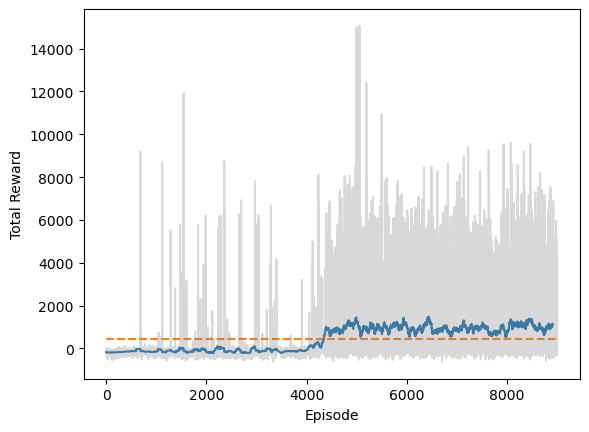

In [58]:
rewards = sarsa(Q, ALPHA, GAMMA, EPSILON, EPSILON_DECAY, EPSILON_MIN, EPISODES)
print('Average training reward: {}'.format(np.mean(rewards)))
plot_rewards(rewards)
plt.show()
env.close()

## Fase 4: Mettiamo alla prova il nostro Lander!

Valutiamo le prestazioni del nostro Lander testandolo su **100 episodi** con la funzione `test`.
Infine, utilizziamo la funzione `view` per eseguire un episodio in modalità grafica e osservare il comportamento dell'agente in azione! Osserva come entrambe le funzioni richiedano come input la QTable `Q` appena addestrata.

In [59]:
print("Number of states in Q-Table:" + str(len(Q)))
test(discretizer, Q)
view(discretizer, Q)

Number of states in Q-Table:1940
Average deployment reward: 129.8085102822938


## Adesso tocca a te! 🚀  

Metti alla prova la funzione `qlearning`, sperimenta con diversi valori dei parametri e cerca di ottimizzare il comportamento dell'agente. Ad esempio, prova a impedire che continui a sprecare carburante dopo l'atterraggio.  

Affina la strategia, migliora le prestazioni e trova la soluzione più efficace. L’unico limite è la tua creatività! 🔥